In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read the words
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
# build the vocabulary of characters and mappings to/from int
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [103]:
# build the dataset
block_size = 3 #context size
X, y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w  + '.':
        ix = stoi[ch]
        #print(context, ix)
        X.append(context)
        y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append
        #print(context, ix)

X = torch.tensor(X)
y = torch.tensor(y)

In [104]:
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [105]:
C = torch.randn((27, 2)) #matrix of embeddings, randomly initialized

In [106]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 1.6232, -1.4736])

In [107]:
emb = C[X] #this gets the embedding for each one of the elements in X
emb.shape

torch.Size([228146, 3, 2])

In [108]:
w1 = torch.rand((6, 100)) # 3x2 input from the embedding, flattened, 100 neurons
b1 = torch.rand(100)

In [109]:
emb.flatten(start_dim=1) #we need the dimensions to match 

tensor([[ 0.7338,  1.3504,  0.7338,  1.3504,  0.7338,  1.3504],
        [ 0.7338,  1.3504,  0.7338,  1.3504,  1.6232, -1.4736],
        [ 0.7338,  1.3504,  1.6232, -1.4736,  0.9399, -0.2783],
        ...,
        [-0.2517, -1.5925, -0.2517, -1.5925,  0.8042, -0.6018],
        [-0.2517, -1.5925,  0.8042, -0.6018, -0.2517, -1.5925],
        [ 0.8042, -0.6018, -0.2517, -1.5925, -0.3396, -0.6364]])

In [110]:
# we need to grab each one of the C elements, 1,2,3 and concatenate
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [111]:
torch.cat(torch.unbind(emb, 1), 1).shape #does the same as the above

torch.Size([228146, 6])

In [113]:
#emb.view(32, 6).shape
emb.view(228146, 6).shape

torch.Size([228146, 6])

In [48]:
# emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [114]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1) #-1 -> python infers the size

# broadcasting -> will be adding the bias to each neuron -> OK
# 32, 100
#   , 100

In [115]:
h.shape

torch.Size([228146, 100])

In [116]:
w2 = torch.rand((100, 27))
b2 = torch.rand(27)

In [117]:
logits = h @ w2 + b2

In [118]:
logits.shape

torch.Size([228146, 27])

In [119]:
counts = logits.exp() #softmax

In [120]:
prob = counts / counts.sum(1, keepdims=True)

In [121]:
prob.shape

torch.Size([228146, 27])

In [124]:
loss = -prob[torch.arange(X.shape[0]), y].log().mean()
loss

tensor(5.0722)

In [125]:
# summary ---------------
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [126]:
sum(p.nelement() for p in parameters)

3481

In [127]:
for p in parameters:
    p.requires_grad = True

In [128]:
epochs = 10
lr = 0.1

for _ in range(epochs):
    
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1) # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), y].log().mean()
    loss = F.cross_entropy(logits, y)
    
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

11.05185604095459


In [83]:
logits.max(1)

torch.return_types.max(
values=tensor([10.8540, 11.1525, 18.0656, 15.3678, 10.7508, 10.8540, 11.5786, 10.2868,
        13.1003, 15.3161, 11.0721, 16.9134, 10.8540, 11.0682, 11.9504, 15.2255,
        10.8540, 12.7962,  9.6893, 11.7940, 15.3628, 11.3616,  6.8681,  5.5033,
        13.4417, 10.8540, 11.5882, 12.6705, 10.6565, 13.5309, 14.1675, 11.0019],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  9,  0,  1, 22, 16,  8,  9,  1,  0]))

In [130]:
torch.randint(0, X.shape[0], (32,))

tensor([160323,  62611,  78875,  36847, 184780, 174519, 174004, 190321, 164337,
        207169, 137558, 125220, 132387, 222600, 210570,  12639,   4767,  88983,
        127124,  99403, 119736, 152107,  45420,  75728,  75269,  23862, 108203,
        205196,   8930,  94536, 177442, 205856])

In [158]:
# summary with minibatch---------------

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True
    
# mini batches

epochs = 1000
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre #exponentially increasing lr

lri = []
lossi = []
for i in range(epochs):
    
    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1) # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), y].log().mean()
    loss = F.cross_entropy(logits, y[ix])
    
    print(loss.item())
    
    # backward pass
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    #track
    lri.append(lr)
    lossi.append(loss.item())
    
print(loss.item())

16.066326141357422
18.883825302124023
22.16991424560547
17.847394943237305
16.618467330932617
18.132909774780273
19.011486053466797
19.810428619384766
16.983810424804688
18.652620315551758
22.91398048400879
16.132978439331055
18.125511169433594
17.718549728393555
20.982837677001953
20.88188362121582
14.020450592041016
17.701988220214844
18.377307891845703
18.59296417236328
16.76576805114746
20.447599411010742
19.664775848388672
15.710786819458008
19.229190826416016
20.863431930541992
16.897289276123047
17.84747314453125
19.953378677368164
19.87102699279785
19.509933471679688
16.954612731933594
15.504241943359375
18.18337059020996
20.385347366333008
20.526220321655273
18.396879196166992
18.155580520629883
18.525705337524414
17.847623825073242
18.822471618652344
17.707372665405273
19.802410125732422
19.744306564331055
20.369762420654297
14.134568214416504
18.194177627563477
20.0283260345459
16.544889450073242
18.31106948852539
16.386268615722656
14.868898391723633
20.48876953125
18.29915

5.145854949951172
3.334893226623535
3.320451259613037
2.942584753036499
3.466183662414551
3.61440372467041
2.827179431915283
3.556065797805786
3.8938448429107666
3.16866397857666
3.6676621437072754
3.0592024326324463
4.104224681854248
3.309983253479004
5.1485371589660645
4.098122596740723
3.103820323944092
3.758160352706909
3.279662847518921
2.9962425231933594
3.6828887462615967
3.4889795780181885
3.7505695819854736
2.9660186767578125
3.6014766693115234
3.7200589179992676
3.974764823913574
3.6580991744995117
2.783867120742798
4.6663689613342285
3.272214412689209
2.8085715770721436
3.7634899616241455
2.8326475620269775
3.4026408195495605
3.0144705772399902
4.270179271697998
3.4495301246643066
3.3320348262786865
3.0904407501220703
3.471945285797119
3.3568060398101807
2.6620304584503174
2.80383563041687
3.2199888229370117
3.232670545578003
3.2446303367614746
3.8745267391204834
3.1547000408172607
3.585581064224243
2.9380431175231934
3.115873098373413
2.8474252223968506
5.192688465118408
3.

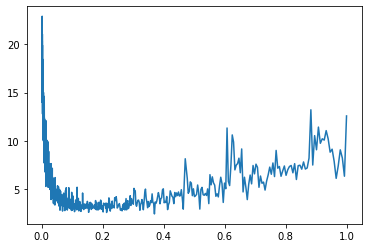

In [159]:
plt.plot(lri, lossi)

In [160]:
import numpy as np
#get the best exponent value for the lr
np.log(lri[np.argmin(lossi)])

tensor(-0.9957)

In [163]:
# summary with minibatch---------------

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True
    
# mini batches

epochs = 1000

loss_vals = []
lr = lri[np.argmin(lossi)]

for i in range(epochs):
    
    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1) # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), y].log().mean()
    loss = F.cross_entropy(logits, y[ix])
    
    print(loss.item())
    
    # backward pass
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters:
        p.data += -lr * p.grad
    
    #track
    loss_vals.append(loss.item())
    
print(loss.item())

17.9448184967041
13.596278190612793
12.21791934967041
9.8433198928833
10.886519432067871
10.688408851623535
10.108210563659668
10.887919425964355
6.824125289916992
8.518367767333984
7.689437389373779
6.258588790893555
7.436258792877197
8.884743690490723
4.872426509857178
6.947742462158203
5.715324878692627
6.321820259094238
6.231869697570801
6.756180286407471
5.279160976409912
6.255960464477539
7.446717739105225
6.08546257019043
5.057581901550293
5.649369716644287
5.8101277351379395
5.389841556549072
5.666682720184326
4.850951194763184
6.090816497802734
4.647154808044434
5.187414646148682
5.228889465332031
5.61154842376709
5.0971784591674805
4.588113307952881
4.34268045425415
3.9535467624664307
4.191209316253662
4.3379902839660645
4.167482852935791
3.766810894012451
4.108343124389648
4.573644161224365
4.003146171569824
4.809467315673828
4.057971000671387
3.867388963699341
4.048369884490967
3.627364158630371
4.571915626525879
4.288142681121826
3.939527988433838
3.603336811065674
3.84551

2.343588352203369
3.278690814971924
3.295715093612671
2.793837070465088
2.7714834213256836
2.8339879512786865
3.1496801376342773
2.7938506603240967
2.9523024559020996
2.8122849464416504
3.007439136505127
2.599874973297119
2.9501800537109375
3.1481266021728516
3.344085931777954
3.5119359493255615
2.3904361724853516
3.342986583709717
2.648164749145508
3.217411756515503
3.4212803840637207
2.969921588897705
2.9963035583496094
3.2854645252227783
2.74481201171875
2.7391750812530518
3.5244545936584473
2.8905344009399414
2.781865119934082
2.1946778297424316
3.141463279724121
2.625049591064453
3.0152475833892822
2.9805004596710205
2.4506912231445312
2.687321662902832
2.9054510593414307
2.771306037902832
2.9857921600341797
2.737893581390381
2.978515386581421
2.7995409965515137
2.868218183517456
3.8464181423187256
3.5510034561157227
3.8927342891693115
3.8006649017333984
2.7239928245544434
3.3796286582946777
3.0048837661743164
3.115579605102539
2.498828172683716
2.600377082824707
2.899186134338379

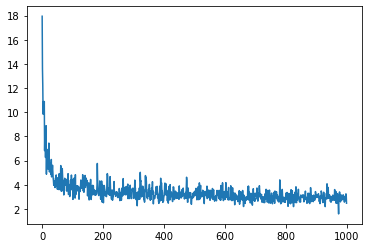

In [164]:
plt.plot(range(epochs), loss_vals)

In [166]:
# test train split 

def build_dataset(words):
    block_size = 3
    X, y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    y = torch.tensor(y)
    
    return X, y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

In [192]:
C.shape[1] * Xtr.shape[1]


30

In [197]:
#  build the training set again for training and validation

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
input_h1 = C.shape[1] * Xtr.shape[1]
w1 = torch.randn((input_h1, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

epochs = 100000
lr = 0.1
min_batch_size = 60
start_decay = 0.9

loss_tr = []
loss_val = []

for i in range(epochs):
    
    #Training
    ix = torch.randint(0, Xtr.shape[0], (min_batch_size,)) #minbatches of 32: out =(32, 6)
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, input_h1) @ w1 + b1) # out = (32, 100)
    logits = h @ w2 + b2 # out = (32, 27)
    loss = F.cross_entropy(logits, ytr[ix])
    
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < epochs * start_decay else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    loss_tr.append(loss.item())
    
    #validation
    ix = torch.randint(0, Xdev.shape[0], (min_batch_size,)) #minbatches of 32: out =(32, 6)
    emb = C[Xdev[ix]]
    h = torch.tanh(emb.view(-1, input_h1) @ w1 + b1) # out = (32, 100)
    logits = h @ w2 + b2 # out = (32, 27)
    loss = F.cross_entropy(logits, ydev[ix])

    loss_val.append(loss.item())
    

#Testing
ix = torch.randint(0, Xte.shape[0], (min_batch_size,)) #minbatches of 32: out =(32, 6)
emb = C[Xte[ix]]
h = torch.tanh(emb.view(-1, input_h1) @ w1 + b1) # out = (32, 100)
logits = h @ w2 + b2 # out = (32, 27)
loss = F.cross_entropy(logits, yte[ix])
print(loss)

tensor(1.9195, grad_fn=<NllLossBackward0>)


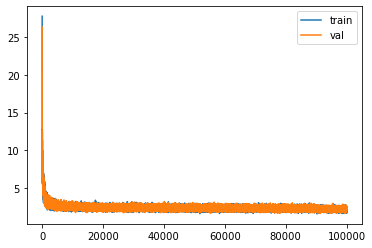

In [198]:
plt.figure()
plt.plot(range(epochs), loss_tr)
plt.plot(range(epochs), loss_val)
plt.legend(['train', 'val'])

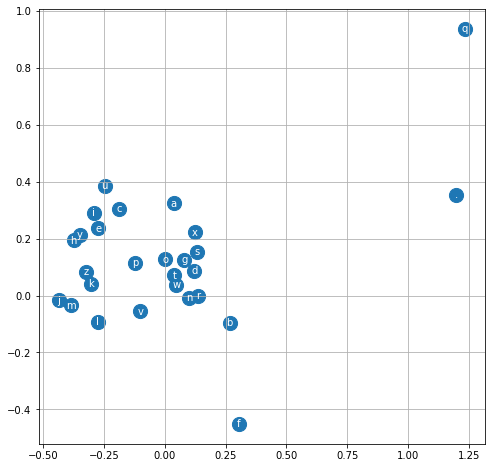

In [195]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

In [ ]:
# if the networkd doesn't work 2 dimensional embeddings could be the issue